In [1]:
%run StatTest2_WithSimulation_Setup.ipynb

In [2]:
data2014 = pd.read_csv("Our_Dataset/2014dataset.csv")
data2015 = pd.read_csv("Our_Dataset/2015dataset.csv")
data2016 = pd.read_csv("Our_Dataset/2016dataset.csv")
data2017 = pd.read_csv("Our_Dataset/2017dataset.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,52,323,649,882,932,1092,1202) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,57,204,341,376,377,396,430,431,928,944,1006,1013,1151,1160,1169,1179,1411) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,17,163,355,406,702,835,847,1083,1156,1183,1185,1200) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Create the labels.
# By index:
# label 2 is transfers
# label 3 is premiums
# label 4 is costs
# label 5 is member months
# label 6 is reinsurance (individual group only)

ind_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                  "HHS RISK ADJUSTMENT TRANSFER AMOUNT (INDIVIDUAL MARKET, INCLUDING CATASTROPHIC)",
                  "1.1Directpremiumwritten2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "2.16Totalincurredclaims2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "7.4Membermonths2HealthInsuranceINDIVIDUALTotalasof3/31/15",
                  "STATE", "REINSURANCE PAYMENT AMOUNT (OR NOT ELIGIBLE)"] # no more reinsurance as of 2017
ind_labels_15 = [label.replace('15', '16') for label in ind_labels_14]
ind_labels_16 = [label.replace('15', '17') for label in ind_labels_14]
ind_labels_17 = [label.replace('15', '18') for label in ind_labels_14][:-1]

sg_labels_14 = ["HIOS ID", "HIOS INPUTTED INSURANCE COMPANY NAME",
                 "HHS RISK ADJUSTMENT TRANSFERS AMOUNT (SMALL GROUP MARKET)",
                  "1.1Directpremiumwritten7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "2.16Totalincurredclaims7HealthInsuranceSMALLGROUPTotalasof3/31/15",
                  "7.4Membermonths7HealthInsuranceSMALLGROUPTotalasof3/31/15", "STATE"]
sg_labels_15 = [label.replace('15', '16') for label in sg_labels_14]
sg_labels_16 = [label.replace('15', '17') for label in sg_labels_14]
sg_labels_17 = [label.replace('15', '18') for label in sg_labels_14]

In [4]:
# Filter the data to include only the fields we want

ind_data_14 = data2014[ind_labels_14].dropna()
ind_data_15 = data2015[ind_labels_15].dropna()
ind_data_16 = data2016[ind_labels_16].dropna()
ind_data_17 = data2017[ind_labels_17].dropna()
sg_data_14 = data2014[sg_labels_14].dropna()
sg_data_15 = data2015[sg_labels_15].dropna()
sg_data_16 = data2016[sg_labels_16].dropna()
sg_data_17 = data2017[sg_labels_17].dropna()

In [5]:
# Drop companies with <2000 MM
ind_data_14 = ind_data_14.where(ind_data_14[ind_labels_14[5]] > 2000).dropna()
ind_data_15 = ind_data_15.where(ind_data_15[ind_labels_15[5]] > 2000).dropna()
ind_data_16 = ind_data_16.where(ind_data_16[ind_labels_16[5]] > 2000).dropna()
ind_data_17 = ind_data_17.where(ind_data_17[ind_labels_17[5]] > 2000).dropna()
sg_data_14 = sg_data_14.where(sg_data_14[sg_labels_14[5]] > 2000).dropna()
sg_data_15 = sg_data_15.where(sg_data_15[sg_labels_15[5]] > 2000).dropna()
sg_data_16 = sg_data_16.where(sg_data_16[sg_labels_16[5]] > 2000).dropna()
sg_data_17 = sg_data_17.where(sg_data_17[sg_labels_17[5]] > 2000).dropna()

In [6]:
# Calculate transfers, premiums, costs, and reinsurance (if individual group) per member month
def calculate_pmm(df, df_labels, group):
    df["MM"] = df[df_labels[5]]
    df["Transfers"] = df[df_labels[2]]
    df["TotalCosts"] = abs(df[df_labels[4]])
    df["Enrollees"] = df["MM"] / 12
    df["TransfersPerEnrollee"] = df["Transfers"] / df["Enrollees"]
    df["TransfersPerSqrtEnrollee"] = df["Transfers"] / np.sqrt(df["Enrollees"])
    df["LogEnrollees"] = np.log(df["Enrollees"])
    df["LogTransfers"] = np.log(df["Transfers"]**2 + 1)
    df["TransfersPMM"] = df[df_labels[2]] / df[df_labels[5]]
    df["PremiumsPMM"] = abs(df[df_labels[3]] / df[df_labels[5]])
    df["CostsPMM"] = abs(df[df_labels[4]] / df[df_labels[5]])
    if group == "i":
        df["ReinsurancePMM"] = df[df_labels[7]] / df[df_labels[5]]
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"] + df["ReinsurancePMM"]
        #df["PremMinusCostsPlusReinsurancePMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["ReinsurancePMM"]
    elif group == "sg":
        df["ProfitsPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["PremMinusCostsPMM"] = df["PremiumsPMM"] - df["CostsPMM"]
    df["PremMinusCostsPlusTransfersPMM"] = df["PremiumsPMM"] - df["CostsPMM"] + df["TransfersPMM"]
    df["SicknessPMM"] = df["CostsPMM"] - df["PremiumsPMM"]
    average_sickness = np.mean(df["SicknessPMM"])
    df["ExcessSicknessPMM"] = df["SicknessPMM"] - average_sickness
    return df

ind_data_14 = calculate_pmm(ind_data_14, ind_labels_14, "i")
ind_data_15 = calculate_pmm(ind_data_15, ind_labels_15, "i")
ind_data_16 = calculate_pmm(ind_data_16, ind_labels_16, "i")
ind_data_17 = calculate_pmm(ind_data_17, ind_labels_17, "sg")
sg_data_14 = calculate_pmm(sg_data_14, sg_labels_14, "sg")
sg_data_15 = calculate_pmm(sg_data_15, sg_labels_15, "sg")
sg_data_16 = calculate_pmm(sg_data_16, sg_labels_16, "sg")
sg_data_17 = calculate_pmm(sg_data_17, sg_labels_17, "sg")

In [7]:
# Combine the dataframes by left merging

ind_data = ind_data_14.merge(ind_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(ind_data_16, on='HIOS ID', how='outer').merge(ind_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [8]:
# Do the same thing for small group

sg_data = sg_data_14.merge(sg_data_15, on='HIOS ID', how='outer', suffixes=('_14', '_15'))\
.merge(sg_data_16, on='HIOS ID', how='outer').merge(sg_data_17, on='HIOS ID', how='outer', suffixes=('_16', '_17'))

In [9]:
states = ["PA", "WI", "OR", "NV", "FL", "VA", "NY", "AZ", "GA", "CO",
          "MI", "ME", "CA", "MO", "OH", "NM", "CT", "MA", "NE", "HI",
          "MN", "AR", "NJ", "MD", "WA", "UT"]
dfs = [sg_data_14, sg_data_15, sg_data_16, sg_data_17]

In [10]:
dfs_new = normalize_empirical_data(dfs, states)

326
338
302
269
PA 14 Ratio is 1.016
WI 14 Ratio is 1.037
OR 14 Ratio is 1.112
NV 14 Ratio is 1.256
FL 14 Ratio is 1.104
VA 14 Ratio is 1.150
NY 14 Ratio is 0.896
AZ 14 Ratio is 1.378
GA 14 Ratio is 1.159
CO 14 Ratio is 1.107
MI 14 Ratio is 1.204
ME 14 Ratio is 1.094
CA 14 Ratio is 1.062
MO 14 Ratio is 1.301
OH 14 Ratio is 1.163
NM 14 Ratio is 1.051
CT 14 Ratio is 0.911
NE 14 Ratio is 1.164
HI 14 Ratio is 1.081
MN 14 Ratio is 1.087
AR 14 Ratio is 1.356
NJ 14 Ratio is 1.079
MD 14 Ratio is 1.140
WA 14 Ratio is 1.103
UT 14 Ratio is 1.498
PA 15 Ratio is 0.986
WI 15 Ratio is 1.011
OR 15 Ratio is 1.047
NV 15 Ratio is 1.198
FL 15 Ratio is 1.069
VA 15 Ratio is 1.168
NY 15 Ratio is 0.825
AZ 15 Ratio is 1.292
GA 15 Ratio is 1.103
CO 15 Ratio is 1.091
MI 15 Ratio is 1.150
ME 15 Ratio is 1.090
CA 15 Ratio is 1.028
MO 15 Ratio is 1.180
OH 15 Ratio is 1.096
NM 15 Ratio is 1.019
CT 15 Ratio is 0.899
NE 15 Ratio is 1.094
HI 15 Ratio is 1.000
MN 15 Ratio is 1.063
AR 15 Ratio is 1.295
NJ 15 Ratio is 0.9

In [11]:
for df_temp in dfs_new:
    df_temp["TransfersNormalizedPerSqrtEnrollee"] = df_temp["TransfersNormalized"] / np.sqrt(df_temp["Enrollees"])

In [12]:
df2 = create_df2(states, dfs_new, "TransfersNormalizedPerSqrtEnrollee")

In [13]:
k = len(df2)
v = np.linspace(0, max(abs(df2)), 10000)
v = v[1:len(v)]

ratios = [ratio_list(df2, vi) for vi in v]
#print(ratios)
begin_p = 5/k
end_p = 1-begin_p
start_index = 0
end_index = 0
for index, ratio2 in enumerate(ratios):
    if ratio2 >= begin_p:
        start_index = index
        break
    
for index, ratio2 in enumerate(ratios):
    if ratio2 > end_p:
        end_index = index
        break

if end_index == 0:
    end_index = len(v) - 1
    
v = v[start_index:end_index]

ratios2 = ratios[start_index:end_index]
multiplier = [np.sqrt(2)/vi for vi in v]
#plt.plot(v, ratios2)
#plt.plot(v, multiplier)

In [14]:
y = [multiplier[i] * special.erfinv(ratio2) for i, ratio2 in enumerate(ratios2)]
#plt.plot(v, y)
#plt.title("1/beta vs. v")
beta = [1/yi for yi in y]
#plt.plot(v, beta)
#plt.axvline(x=64432.69, color='r', linestyle='--', label="Point of max difference")
#plt.title("beta vs. v")

In [15]:
# Finding the minimum beta
# Whenever we reject a beta, we reject all betas greater than that,
# so keep pushing beta smaller until we reach max_difference == test_statistic
# Run test for larger data sizes (combining states, years)

In [16]:
max_beta=max(beta)
max_beta = int(max_beta/100)*100

In [17]:
state_label = "Competitive States"

beta = 111300.000


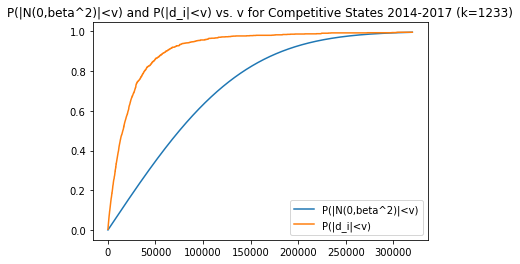

In [18]:
theoretical = [special.erf(vi/(max_beta*np.sqrt(2))) for vi in v]

plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v)")
plt.plot(v, ratios2, label="P(|d_i|<v)")
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for %s 2014-2017 (k=%d)" % (state_label, len(df2)))
#plt.axvline(x=64432.69, color='r', linestyle='--', label="Point of max difference")
plt.legend()
print("beta = %.3f" % (max_beta))

In [19]:
beta1, Mb_index = run_test_against_theoretical(df2, max_beta, ratios2)

k = 1233
test_stat at this k = 0.03868

At the point of maximum difference with beta = 111300:
P(|d_i|<v) = 0.8191
P(|N(0,max_beta^2)|<v) = 0.2870
Difference = 0.5322




At the point of maximum difference with beta = 101300:
P(|d_i|<v) = 0.8013
P(|N(0,max_beta^2)|<v) = 0.2948
Difference = 0.5065




At the point of maximum difference with beta = 91300:
P(|d_i|<v) = 0.7397
P(|N(0,max_beta^2)|<v) = 0.2590
Difference = 0.4806




At the point of maximum difference with beta = 81300:
P(|d_i|<v) = 0.7397
P(|N(0,max_beta^2)|<v) = 0.2895
Difference = 0.4501




At the point of maximum difference with beta = 71300:
P(|d_i|<v) = 0.7397
P(|N(0,max_beta^2)|<v) = 0.3279
Difference = 0.4117




At the point of maximum difference with beta = 61300:
P(|d_i|<v) = 0.7397
P(|N(0,max_beta^2)|<v) = 0.3775
Difference = 0.3621




At the point of maximum difference with beta = 51300:
P(|d_i|<v) = 0.7324
P(|N(0,max_beta^2)|<v) = 0.4360
Difference = 0.2964




At the point of maximum difference with beta = 4


At the point of maximum difference with beta = 25200:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2678
Difference = 0.0655




At the point of maximum difference with beta = 25100:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2688
Difference = 0.0645




At the point of maximum difference with beta = 25000:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2699
Difference = 0.0635




At the point of maximum difference with beta = 24900:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2709
Difference = 0.0624




At the point of maximum difference with beta = 24800:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2719
Difference = 0.0614




At the point of maximum difference with beta = 24700:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2730
Difference = 0.0603




At the point of maximum difference with beta = 24600:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2741
Difference = 0.0593




At the point of maximum difference with beta = 24500:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta

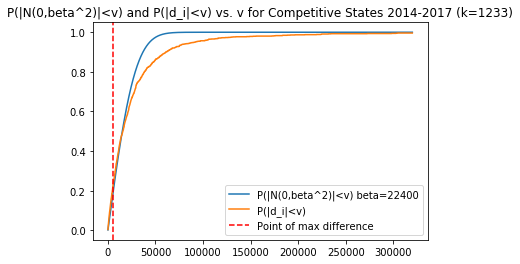

In [20]:
beta1 = beta1+100

theoretical = [special.erf(vi/(beta1*np.sqrt(2))) for vi in v]

plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v) beta=%d" % (beta1))
plt.plot(v, ratios2, label="P(|d_i|<v)")
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for %s 2014-2017 (k=%d)" % (state_label, len(df2)))
plt.axvline(x=v[Mb_index], color='r', linestyle='--', label="Point of max difference")
plt.legend()
#plt.xlim(0, 50000)
#print("beta = %.3f" % (max_beta))

In [21]:
run_binom_stat_test2(beta1, df2.values)

Beta (=std): 22400
Number of T/sqrt(n) above 2 stds: 206
Proportion of T/sqrt(n) above 2 stds: 0.167
P value = 0.000000


In [22]:
df3 = create_df3(states, dfs_new)

In [23]:
ratios_c = create_simulation_adjust_for_imbalances(states, dfs_new, beta1 - 10000)
ratios_c2 = create_simulation_adjust_for_imbalances(states, dfs_new, beta1)
ratios_c3 = create_simulation_adjust_for_imbalances(states, dfs_new, beta1 + 10000)

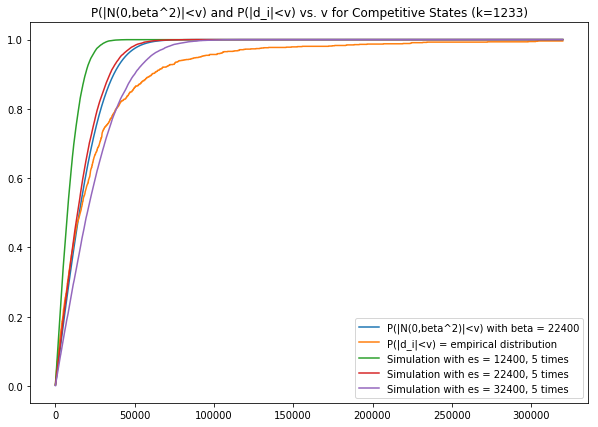

In [24]:
theoretical = [special.erf(vi/(beta1*np.sqrt(2))) for vi in v]

plt.figure(figsize=(10, 7))
plt.plot(v, theoretical, label="P(|N(0,beta^2)|<v) with beta = %d" % (beta1))
plt.plot(v, ratios2, label="P(|d_i|<v) = empirical distribution")
plt.plot(v, ratios_c, label="Simulation with es = %d, 5 times" % (beta1 - 10000))
plt.plot(v, ratios_c2, label="Simulation with es = %d, 5 times" % (beta1))
plt.plot(v, ratios_c3, label="Simulation with es = %d, 5 times" % (beta1 + 10000))
plt.title("P(|N(0,beta^2)|<v) and P(|d_i|<v) vs. v for %s (k=%d)" % (state_label, len(df2)))
plt.legend()

In [25]:
beta1, _ = run_test_against_simulation_adjust_for_imbalances(states, dfs_new, beta1, ratios2)

k = 1233
test_stat at this k = 0.03868

At the point of maximum difference with beta = 22400:
P(|d_i|<v) = 0.1419
P(|N(0,max_beta^2)|<v) = 0.1142
Difference = 0.0277 NOT > test_stat

At the point of maximum difference with beta = 32400:
P(|d_i|<v) = 0.4250
P(|N(0,max_beta^2)|<v) = 0.3174
Difference = 0.1076




At the point of maximum difference with beta = 32300:
P(|d_i|<v) = 0.4663
P(|N(0,max_beta^2)|<v) = 0.3533
Difference = 0.1130




At the point of maximum difference with beta = 32200:
P(|d_i|<v) = 0.3763
P(|N(0,max_beta^2)|<v) = 0.2702
Difference = 0.1061




At the point of maximum difference with beta = 32100:
P(|d_i|<v) = 0.4558
P(|N(0,max_beta^2)|<v) = 0.3414
Difference = 0.1144




At the point of maximum difference with beta = 32000:
P(|d_i|<v) = 0.4517
P(|N(0,max_beta^2)|<v) = 0.3365
Difference = 0.1153




At the point of maximum difference with beta = 31900:
P(|d_i|<v) = 0.4250
P(|N(0,max_beta^2)|<v) = 0.3149
Difference = 0.1100




At the point of maximum difference wi


At the point of maximum difference with beta = 26200:
P(|d_i|<v) = 0.2198
P(|N(0,max_beta^2)|<v) = 0.1704
Difference = 0.0494




At the point of maximum difference with beta = 26100:
P(|d_i|<v) = 0.2214
P(|N(0,max_beta^2)|<v) = 0.1735
Difference = 0.0479




At the point of maximum difference with beta = 26000:
P(|d_i|<v) = 0.2198
P(|N(0,max_beta^2)|<v) = 0.1752
Difference = 0.0446




At the point of maximum difference with beta = 25900:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2892
Difference = 0.0441




At the point of maximum difference with beta = 25800:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2881
Difference = 0.0452




At the point of maximum difference with beta = 25700:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2859
Difference = 0.0475




At the point of maximum difference with beta = 25600:
P(|d_i|<v) = 0.3333
P(|N(0,max_beta^2)|<v) = 0.2869
Difference = 0.0464




At the point of maximum difference with beta = 25500:
P(|d_i|<v) = 0.2214
P(|N(0,max_beta

In [26]:
run_binom_stat_test2(beta1, df2.values)

Beta (=std): 24700
Number of T/sqrt(n) above 2 stds: 175
Proportion of T/sqrt(n) above 2 stds: 0.142
P value = 0.000000
